# Systems perturbation of links in the biochemical cascade network

## Init

In [1]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path+'\src')
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\new-peak-project\src


In [2]:
from dotenv import dotenv_values
config = dotenv_values(".env")
print(config["DATA_PATH"])

G:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


In [3]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *
from models.Utils import *

import matplotlib.pyplot as plt
import seaborn as sns
import roadrunner
import numpy as np
import pandas as pd

# import scikit-learn
from sklearn.linear_model import LinearRegression
# tree models and support vector machines
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import pearson correlation
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from copy import deepcopy

In [4]:
import os 

### parameters 

notebook_name = 'systems_perturbation_dyn_feats'
plot_figures = True
run_jobs = False
parallelise = True
save_figures = True

## Generation of ground truth model 

model_name = 'v3_small_model_52'
o_random_seed = 4
no_observable_species = 5
no_feedback_regulations = 2
specie_value_range = (5, 5000)
param_range = (0.1, 10)
param_multiplier_range = (0.7, 1.3)


## Simulation parameters 

simulation_time = 500 
simulation_step = 100

## Feature data generation 

feature_generation_method = 'uniform'
feature_generation_extra_params = {'min': 0.1, 'max': 10}
feature_generation_size = 1000 
feature_generation_seed = 50 # if -1 then 'o_random_seed' is used
if feature_generation_seed == -1:
    feature_generation_seed = o_random_seed
''' 
Options: 
- 'last_time_point' : only the last time point of the phosphorylated species is used
- 'dynamic_feature': computes the characteristic 'ten' dynamic feature for each specie data 
'''

## General parameters 
experiment_id = notebook_name + '_' + str(o_random_seed) + '_' + str(feature_generation_seed)
experiment_folder = config['DATA_PATH'] + '/' + experiment_id + '/'
if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)
    
print(experiment_folder)

G:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/systems_perturbation_dyn_feats_4_50/


## Perturbation

### Generate ground truth model

In [5]:
### Generate the ground truth model

model_spec = ModelSpecification()
model_spec.generate_specifications(o_random_seed, no_observable_species, no_feedback_regulations, verbose=0)
G0 = model_spec.generate_network(model_name, specie_value_range, param_range, param_multiplier_range, random_seed=o_random_seed, verbose=0)
runner = roadrunner.RoadRunner(G0.get_sbml_model())
res = runner.simulate(0, simulation_time, simulation_step)

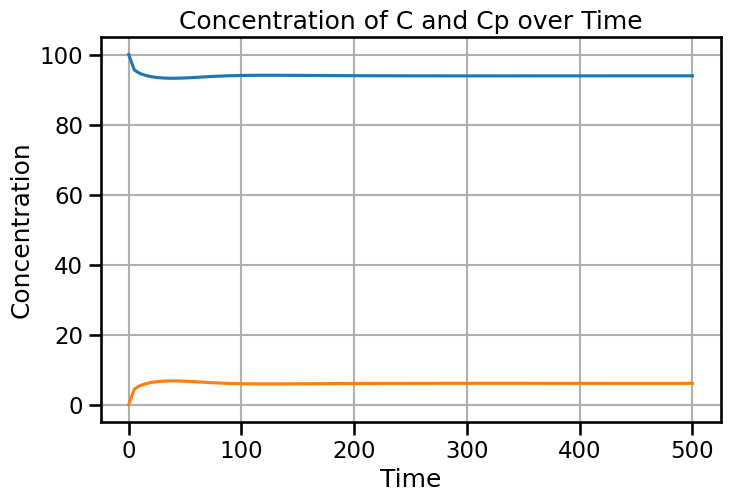

In [6]:
# === PLOT: Visible States Over Time ===

if plot_figures:

    import seaborn as sns
    sns.set_context('talk')
    sns.axes_style('whitegrid')

    # Initialize RoadRunner and simulate the model
    runner = roadrunner.RoadRunner(G0.get_sbml_model())
    res = runner.simulate(0, simulation_time, simulation_step)

    # Define key observable states
    visible_states = ['C', 'Cp']

    # Plot the concentration of visible states over time
    plt.figure(figsize=(8, 5))
    for state in visible_states:
        plt.plot(res['time'], res[f'[{state}]'], label=state)

    # Formatting the plot
    plt.xlabel("Time")
    plt.ylabel("Concentration")
    plt.title("Concentration of C and Cp over Time")
    plt.grid(True)

    if save_figures:
        plt.savefig(experiment_folder + 'Fig_01_C_Cp_time_course_ground_truth.png')
    plt.show()

### Generate synthetic data

In [7]:
### Generate the synthetic data

feature_df = generate_feature_data(model_spec, runner, feature_generation_method, feature_generation_extra_params, feature_generation_size, seed=feature_generation_seed)
initial_values = get_model_initial_values(model_spec, runner)

target_df, time_course_data = generate_target_data(model_spec, runner, feature_df, initial_values)

### Generate suboptimal models (n edge removed random)

In [ ]:
n_sub = 10
suboptimal_models_rms = {}
suboptimal_models_spec_rms = {}

n_edge_removed_range = (2,9)

for n_edge_removed in range(n_edge_removed_range[0], n_edge_removed_range[1]+1):
    suboptimal_models_rms[n_edge_removed] = []
    suboptimal_models_spec_rms[n_edge_removed] = []
    for i in range(n_sub):
        s_spec, s_model = systematic_edge_pruning(model_spec, G0, n_edge_removed, random_seed=i)
        suboptimal_models_spec_rms[n_edge_removed].append(s_spec)
        suboptimal_models_rms[n_edge_removed].append(s_model)

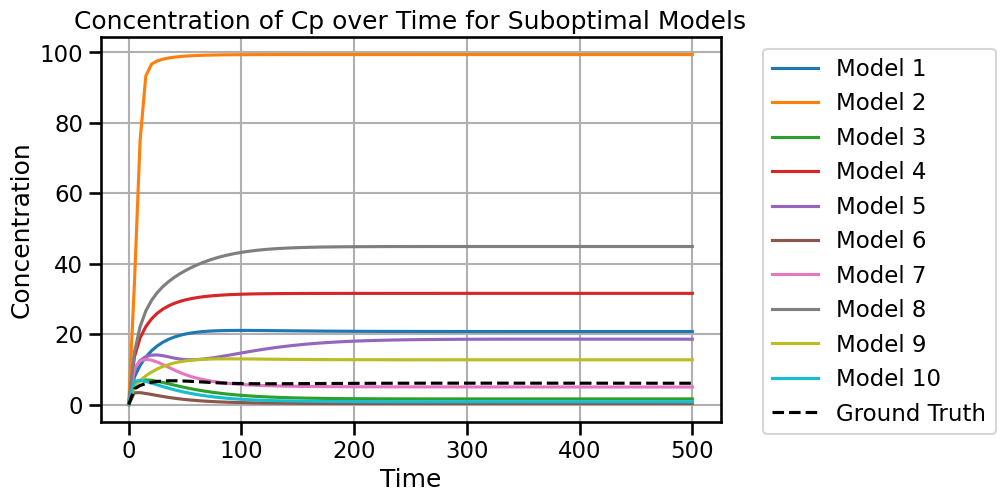

In [17]:
if plot_figures:
    # Visualise the behaviour of the suboptimal models, plot the original model as reference comparison
    plt.figure(figsize=(8, 5))

    for i, s_model in enumerate(suboptimal_models_rms[5]):
        runner = roadrunner.RoadRunner(s_model.get_sbml_model())
        res = runner.simulate(0, simulation_time, simulation_step)
        plt.plot(res['time'], res['[Cp]'], label=f"Model {i+1}")
        
    runner = roadrunner.RoadRunner(G0.get_sbml_model())
    res = runner.simulate(0, simulation_time, simulation_step)
    plt.plot(res['time'], res['[Cp]'], label="Ground Truth", linestyle='dashed', color='black')
        
    plt.xlabel("Time")
    plt.ylabel("Concentration")
    plt.title("Concentration of Cp over Time for Suboptimal Models")
    plt.grid(True)
    # set the legend to be outside the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

### Generate timecourse data from ground truth model

In [ ]:
# obtain the last time point for each phosphorylated species
all_species = model_spec.A_species + model_spec.B_species + model_spec.C_species
all_phos_species = [s+'p' for s in all_species]
all_time_course_data_G0 = generate_model_timecourse_data(model_spec, runner, feature_df, initial_values)
all_time_course_data_phos_G0 = all_time_course_data_G0[all_phos_species]
dynamic_feature_df_G0 = last_time_point_method(all_time_course_data_G0, all_phos_species)


if run_jobs:
    time_course_data_rm_all = {}
    all_species = model_spec.A_species + model_spec.B_species + model_spec.C_species
    all_phos_species = [s+'p' for s in all_species]

    for n_edge_removed in range(n_edge_removed_range[0], n_edge_removed_range[1]+1):
        time_course_data_rm = []
        for i in range(n_sub):
            s_spec = suboptimal_models_spec_rms[n_edge_removed][i]
            s_model = suboptimal_models_rms[n_edge_removed][i]
            runner = roadrunner.RoadRunner(s_model.get_sbml_model())
            time_course_data = generate_model_timecourse_data(s_spec, runner, feature_df, initial_values)
            time_course_data_rm.append(time_course_data)
        time_course_data_rm_all[n_edge_removed] = time_course_data_rm
        

if run_jobs:
    dynamic_features_rm_all = {}
    for n_edge_removed in range(n_edge_removed_range[0], n_edge_removed_range[1]+1):
        dynamic_features_rm = []
        for i in range(n_sub):
            time_course_data = time_course_data_rm_all[n_edge_removed][i]
            dynamic_features = dynamic_features_method(time_course_data, all_phos_species)
            dynamic_features_rm.append(dynamic_features)
        dynamic_features_rm_all[n_edge_removed] = dynamic_features_rm

### Machine learning on G0 last time point features and all 2rm suboptimal models

In [ ]:
def evaluate_model(model, model_name, feature_data, feature_data_name, target_data ,test_size=0.2, random_state=4):
    X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, test_size=test_size, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # return a dictionary of the model performance
    return {'Model': model_name, 
            'Feature Data': feature_data_name,
            'Mean Squared Error': mean_squared_error(y_test, y_pred),
            'R2 Score': r2_score(y_test, y_pred),
            'Pearson Correlation': pearsonr(y_test, y_pred)[0],
            'Pearson P-Value': pearsonr(y_test, y_pred)[1]
            }
# create a linear regression model
lm = LinearRegression()
# create a random forest model
rf = RandomForestRegressor(n_estimators=100, random_state=o_random_seed)
# create a gradient boosting model
gb = GradientBoostingRegressor(n_estimators=100, random_state=o_random_seed)
# create a support vector machine model
svr = SVR(max_iter=10000)
scaled_svr = Pipeline([('scaler', StandardScaler()), ('svr', svr)])
# create a neural network model (simple)
nn = MLPRegressor(hidden_layer_sizes=(20,), max_iter=10000, random_state=o_random_seed)
scaled_nn = Pipeline([('scaler', StandardScaler()), ('nn', nn)])


all_metric_dfs = {}

for n_edge_removed in range(n_edge_removed_range[0], n_edge_removed_range[1]+1):
    dynamic_features = dynamic_features_rm_all[n_edge_removed]


    all_models = [lm, rf, gb, scaled_svr, scaled_nn]
    all_models_desc = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Support Vector Machine', 'Neural Network']
    zipped_model_data = list(zip(all_models, all_models_desc))
    all_features = [feature_df, dynamic_feature_df_G0] + dynamic_features
    all_features_desc = ['Mock Omics Data (A+B)', 'Last Point G0'] + [f'Last Point S{i+1} {n_edge_removed}rm' for i in range(n_sub)]
    zipped_feature_data = list(zip(all_features, all_features_desc))

    # random states are rand ints between 0 and 10000, for n values 
    np.random.seed(o_random_seed)
    n_random = 10
    all_random_states = np.random.randint(0, 10000, n_random)

    if run_jobs: 
        metric_data = []
        if not parallelise:          
            for (feature_data, feature_data_name) in zipped_feature_data:
                # print('Feature Data:', feature_data_name)
                # print('Feature Data Shape:', feature_data.shape)
                for (model, model_name) in zipped_model_data:
                    # print('Model:', model_name)
                    for rand in all_random_states:
                        metrics = evaluate_model(model, model_name, feature_data, feature_data_name, target_df['Cp'], random_state=rand)
                        metric_data.append(metrics)
                        
        else:        
            # parallelise the model evaluation process using joblib
            from joblib import Parallel, delayed

            metric_data = Parallel(n_jobs=-1)(delayed(evaluate_model)(model, model_name, feature_data, feature_data_name, target_df['Cp'], random_state=rand) 
                                            for (feature_data, feature_data_name) in zipped_feature_data
                                            for (model, model_name) in zipped_model_data
                                            for rand in all_random_states)

        # make a dataframe of the metric data
        metric_df = pd.DataFrame(metric_data)
        # add a column for the number of edges removed
        metric_df['Edges Removed'] = n_edge_removed
        # add the dataframe to the dictionary
        all_metric_dfs[n_edge_removed] = metric_df
        print('--- Finished evaluating models for', n_edge_removed, 'edges removed ---')

NameError: name 'last_time_points_4rm' is not defined

In [ ]:
# save metric_df 
if save_figures and run_jobs: 
    for n_edge_removed in range(n_edge_removed_range[0], n_edge_removed_range[1]+1):
        all_metric_dfs[n_edge_removed].to_pickle(experiment_folder + f'{n_edge_removed}rm_metric_df.pkl')

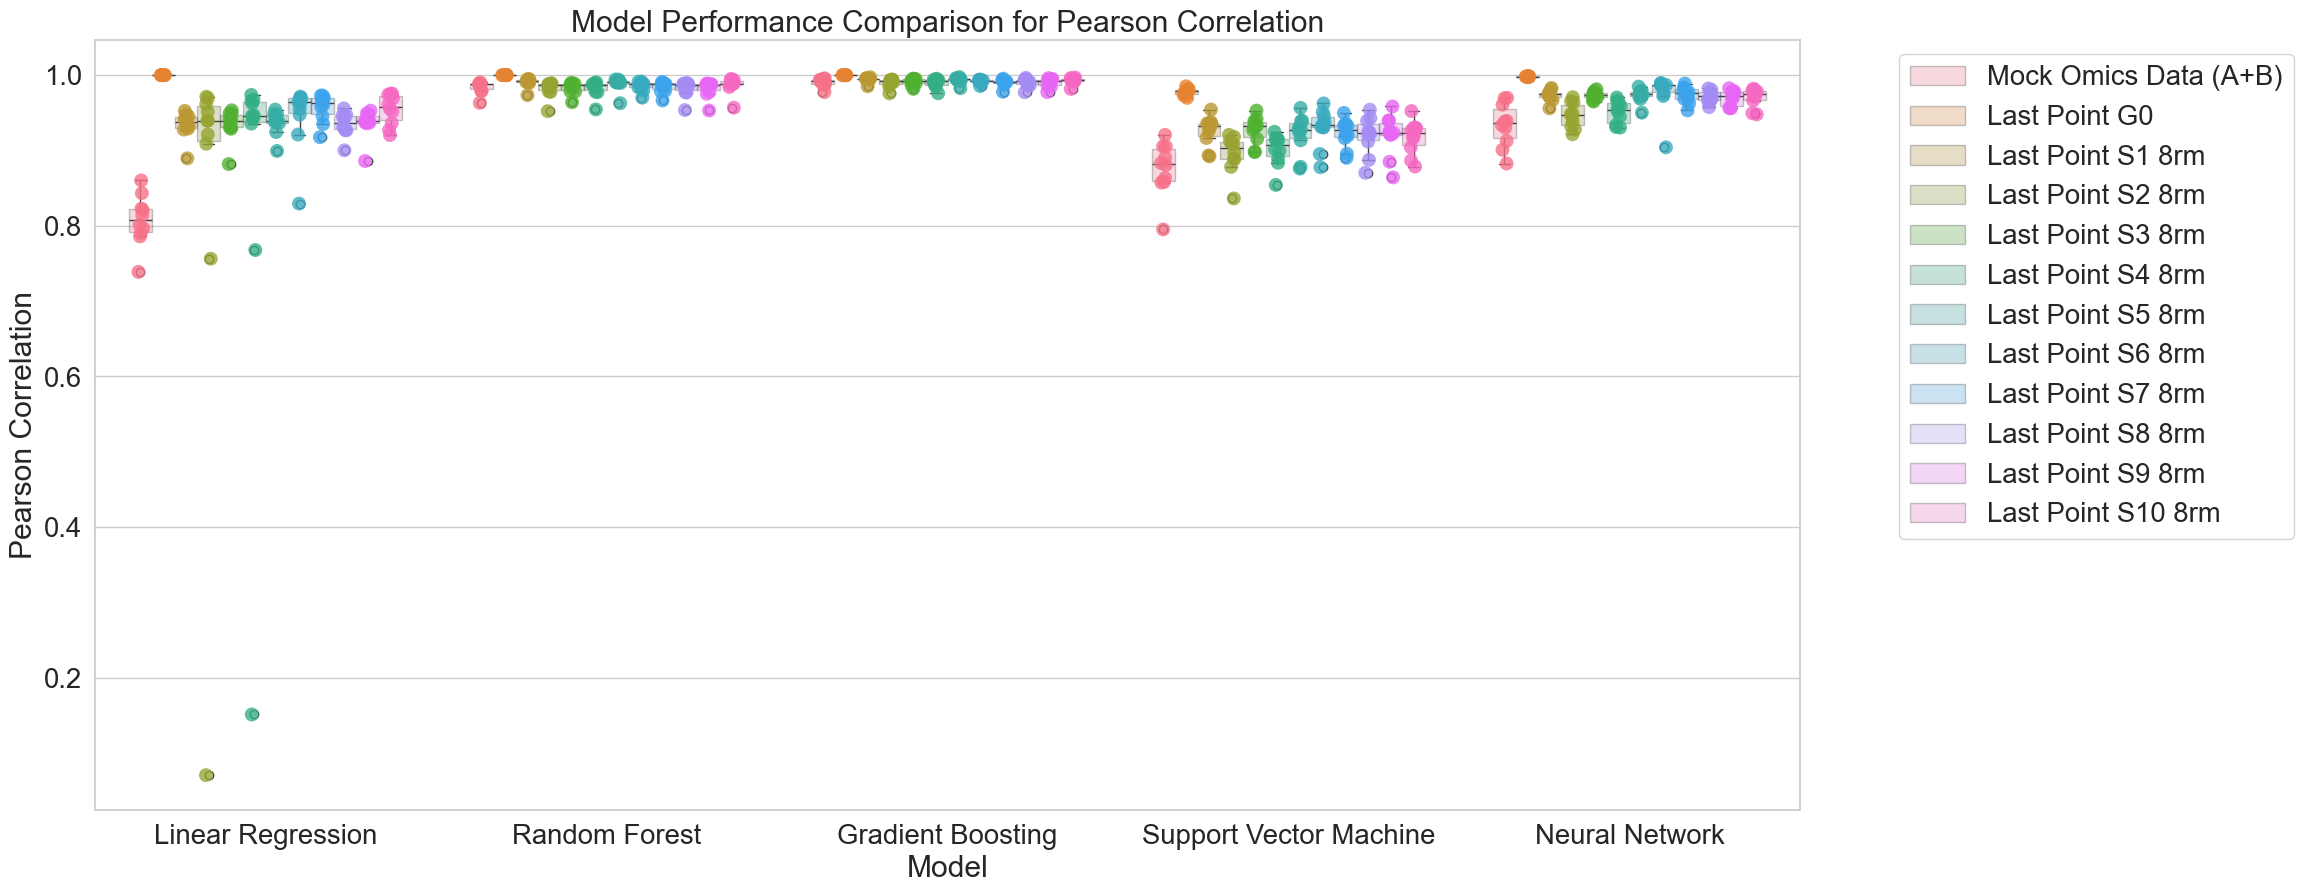

In [14]:
if plot_figures:

    # load metric_df from data_path
    metric_df = pd.read_pickle(experiment_folder+'8rm_metric_df.pkl')

    sns.set(rc={'figure.figsize':(22,10)})
    # make the font size bigger for labels and title, and axes labels 
    sns.set(font_scale=1.8)
    sns.set_style("whitegrid")
    sns.stripplot(data=metric_df, x='Model', y='Pearson Correlation', hue='Feature Data', dodge=True, jitter=True, size=10, alpha=0.8, legend=False)

    # display the mean value for each model and feature data type
    mean_vals = metric_df.groupby(['Model', 'Feature Data']).mean().reset_index()
        

    # make a transparent box plot, without using the alpha parameter
    sns.boxplot(data=metric_df, x='Model', y='Pearson Correlation', hue='Feature Data')
    for patch in plt.gca().patches:
        patch.set_alpha(0.3)

    plt.title('Model Performance Comparison for Pearson Correlation')

    if save_figures:
        plt.savefig(experiment_folder + f'Fig_9rm_model_performance_all.png')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [8]:
if plot_figures:

    # visualise the performance of the models
    # create box plots for each model type and feature data type, plot for pearson correlation

    # load metric_df from data_path 
    metric_df = pd.read_pickle(experiment_folder+'3rm_metric_df.pkl')

    # plot each model individually

    for model_desc in all_models_desc: 
        new_metric_df = metric_df[metric_df['Model'] == model_desc]
        sns.set(rc={'figure.figsize':(22,10)})
        # make the font size bigger for labels and title, and axes labels 
        sns.set(font_scale=1.8)
        sns.set_style("whitegrid")
        sns.stripplot(data=new_metric_df, x='Feature Data', y='Pearson Correlation', hue='Feature Data', jitter=True, size=10, alpha=0.8)
        # display the mean value for each model and feature data type
        mean_vals = new_metric_df.groupby(['Model', 'Feature Data']).mean().reset_index()
            
        # make a transparent box plot, without using the alpha parameter
        # ensure the box plot is centered on the strip plot
        sns.boxplot(data=new_metric_df, x='Feature Data', y='Pearson Correlation', hue='Feature Data')
        for patch in plt.gca().patches:
            patch.set_alpha(0.5)

        plt.title(f'Model performance comparison for {model_desc} - Pearson Correlation of suboptimal models (9 edges removed)')
        # make the x-axis labels vertical
        plt.xticks(rotation=90)

        if save_figures:
            plt.savefig(experiment_folder + f'Fig_4rm_model_performance_{model_desc}.png')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()
    


NameError: name 'all_models_desc' is not defined